In [1]:
# Add the source directory to the path
import sys
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD/src')
sys.path.append('/home/sleyse4/repos/LoRE_SD/LoRE-SD')


In [2]:
import os
import subprocess
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import gradient_utils, plot_utils, io_utils, math_utils
from optimisation import optimise

import contrasts

from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

import utils.SphericalHarmonics as sh

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.transforms import Bbox

In [3]:
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

In [4]:
sub = 'PT015'
DATASERVER = f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-{sub}'

data = load_mrtrix(f'{DATASERVER}/LoRE/response.mif')
mask = load_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/sub-{sub}/PREPROC/mask.mif').data > .5
gm_segmentation = load_mrtrix(f'{DATASERVER}/5tt_regrid.mif').data[...,0] > .9
wm_segmentation = load_mrtrix(f'{DATASERVER}/5tt_regrid.mif').data[...,2] > .9
csf_segmentation = load_mrtrix(f'{DATASERVER}/5tt_regrid.mif').data[...,3] > .9

reg = np.sum(data.data[..., 1:, 1:]/data.data[...,:1,:1] ** 2, axis=(-1,-2))

SLICE_IDX = 70


grad = load_mrtrix(f'/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/sub-{sub}/PREPROC/biascorr.mif').grad
bvals = np.unique(np.round(grad[:,-1], -2))
rf = data.data
fracs = load_mrtrix(f'{DATASERVER}/LoRE/gaussian_fractions.mif').data
mask = mask
vox = data.vox

/tmp/ipykernel_4151698/2529735309.py:10: RuntimeWarning: invalid value encountered in divide
  reg = np.sum(data.data[..., 1:, 1:]/data.data[...,:1,:1] ** 2, axis=(-1,-2))


In [5]:
def fa_map(ad, rd):

    ad_matrix = np.repeat(ad[..., None], len(rd), axis=-1)
    rd_matrix = np.repeat(rd[None, ...], len(ad), axis=0)

    mask = ad_matrix >= rd_matrix
    ad_matrix *= mask
    rd_matrix *= mask

    lambda_mean = (ad_matrix + 2*rd_matrix) / 3
    return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))

def exponential_weighting(ad_range, rd_range, centers=None, scales=1):
    # Create a 10x10 matrix filled with zeros
    if centers is None:
        raise Exception('Please provide centers as a list of 2D coordinates')

    out = np.zeros((len(ad_range), len(rd_range)))

    # Generate exponential values centered around [9,9]
    for i, ad in enumerate(ad_range):
        for j, rd in enumerate(rd_range):
            if ad >= rd:
                # Calculate distance from [9,9]
                distances = np.asarray([np.sqrt((ad - x) ** 2 + (rd - y) ** 2) for (x, y) in centers])
                # Assign exponential value to the cell
                out[i, j] = np.max(np.exp(-distances / scales))

    return out / np.max(out)


def gm_map(ad, rd):
    centers = [
        (.7e-3, .7e-3),
        (1e-3, 1e-3)
    ]
    return exponential_weighting(ad, rd, centers=centers, scales=.0001)

def normalise_0_1(vals):
    return (vals - np.min(vals)) / (np.max(vals) - np.min(vals))

# Define decreasing functions
def sigmoid_function(vals, reverse=False, k=20, x0=0.15):
    if not reverse:
        return normalise_0_1(np.array([1 - 1 / (1 + np.exp(-k * (j - x0))) for j in normalise_0_1(vals)]))
    else:
        return normalise_0_1(np.array([1 - 1 / (1 + np.exp(-k * (vals[-1] - (j - x0)))) for j in normalise_0_1(vals)]))
    
def gaussian_function(vals, reverse=False, mu=0.5, sigma=0.1):
    if not reverse:
        return normalise_0_1(np.array([np.exp(-((j - mu) ** 2) / (2 * sigma ** 2)) for j in normalise_0_1(vals)]))
    else:
        return normalise_0_1(np.array([np.exp(-((vals[-1] - j - mu) ** 2) / (2 * sigma ** 2)) for j in normalise_0_1(vals)]))
    
def to_decay_matrix(ad, rd, decay_function, axis='radial', with_isotropic=True, **kwargs):
    unit_matrix = ad[:, None] >= rd[None] if with_isotropic else ad[:, None] > rd[None]
    if axis == 'radial':
        dec = decay_function(rd, **kwargs)
        dec = np.repeat(dec[None], repeats=len(ad), axis=0)
    elif axis == 'axial':
        dec = decay_function(ad, **kwargs)
        dec = np.repeat(dec[:, None], repeats=len(rd), axis=1)
    else:
        raise ValueError('Axis must be either "radial" or "axial"')
    return unit_matrix * dec


In [6]:
def cosine_similarity(a, b):
    assert a.shape[-1] == b.shape[-1], 'The matrices must have the same last dimension'
    return np.sum(a * b, axis=-1) / (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1))

def to_contrast(fracs, matrix):
    return np.sum(fracs * matrix, axis=(-1, -2))

In [7]:
ad, rd = np.linspace(0, 4e-3, 10), np.linspace(0, 4e-3, 10)

In [8]:
from scipy.ndimage import gaussian_filter

/tmp/ipykernel_4151698/1455473264.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))


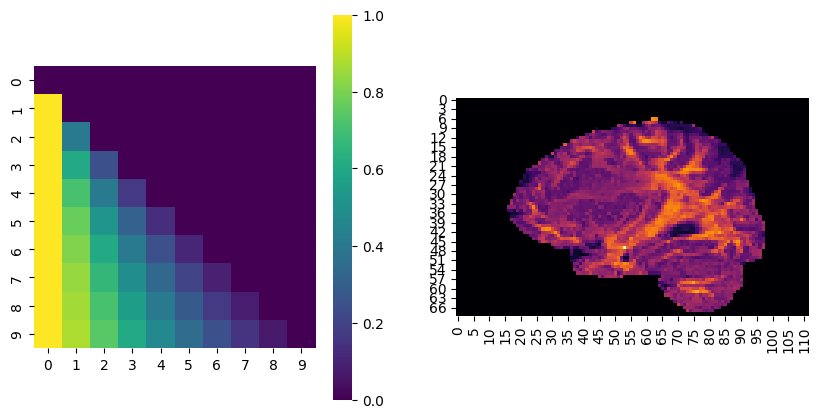

In [9]:
iax_matrix = contrasts.intra_axonal_contrast(ad, rd, with_isotropic=False, rate=10)
t_matrix = to_decay_matrix(ad, rd, gaussian_function, axis='radial', mu=0.7, sigma=0.1)
matrix = fa_map(ad, rd)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(matrix, cmap='viridis', ax=axs[0], square=True)
sns.heatmap(np.fliplr(np.rot90(np.sum(fracs * matrix, axis=(-1,-2))[SLICE_IDX])), square=True, cbar=False, cmap='inferno', ax=axs[1], vmin=0)
save_mrtrix(os.path.join(DATASERVER, 'estimate.mif'), Image(np.sum(fracs * matrix, axis=(-1,-2)), vox=data.vox))

In [10]:
HEALTHY_DATASERVER = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/philips'
fracs_healthy = load_mrtrix(f'{HEALTHY_DATASERVER}/LoRE/gaussian_fractions.mif').data

wm_target = load_mrtrix(f'{HEALTHY_DATASERVER}/MTCSD/wm.mif').data[...,0]
gm_target = load_mrtrix(f'{HEALTHY_DATASERVER}/MTCSD/gm.mif').data[...,0]
csf_target = load_mrtrix(f'{HEALTHY_DATASERVER}/MTCSD/csf.mif').data[...,0]

import cvxopt
def target2matrix(target, fracs, ad, rd):
    C_cvx = cvxopt.matrix(target.flatten().astype(np.float64))
    W_cvx = cvxopt.matrix(fracs.reshape((-1, len(ad), len(rd)))[...,ad[:,None] >= rd[None]].astype(np.float64))
    P = W_cvx.T * W_cvx
    q = -W_cvx.T * C_cvx

    G = cvxopt.matrix(-np.eye(W_cvx.size[1]))
    h = cvxopt.matrix(np.zeros(W_cvx.size[1]))

    sol = cvxopt.solvers.qp(P, q, G, h)
    f = np.array(sol['x']).flatten()
    out = np.zeros((len(ad), len(rd)))
    out[ad[:,None] >= rd[None]] = f
    return out

wm_matrix = gaussian_filter(target2matrix(wm_target, fracs_healthy, ad, rd), .5)
gm_matrix = gaussian_filter(target2matrix(gm_target, fracs_healthy, ad, rd), .5)
csf_matrix = gaussian_filter(target2matrix(csf_target, fracs_healthy, ad, rd), .5)

tissue_matrices = [wm_matrix, gm_matrix, csf_matrix]
tissue_titles = ['WM', 'GM', 'CSF']
tissue_contrasts = [to_contrast(fracs_healthy, matrix) for matrix in tissue_matrices]

iax_matrix = contrasts.intra_axonal_contrast(ad, rd)
eax_matrix = contrasts.extra_axonal_contrast(ad, rd)
fw_matrix = contrasts.free_water_contrast(ad, rd)

micro_matrices = [iax_matrix, eax_matrix, fw_matrix]
micro_titles = ['Intra-axonal compartment', 'Extra-axonal compartment', 'Free water compartment']
micro_contrasts = [to_contrast(fracs_healthy, matrix) for matrix in micro_matrices]

fa_matrix = fa_map(ad, rd)

matrices = [iax_matrix, eax_matrix, fw_matrix, wm_matrix, gm_matrix, csf_matrix, fa_matrix]
names = ['Intra-axonal compartment', 'Extra-axonal compartment', 'Free water compartment', 'WM', 'GM', 'CSF', 'Response function anisotropy']
contrast_list = [to_contrast(fracs_healthy, matrix) for matrix in matrices]

     pcost       dcost       gap    pres   dres
 0: -1.3541e+03 -1.3598e+03  1e+02  9e+00  3e-03
 1: -1.3532e+03 -1.3569e+03  2e+01  2e+00  6e-04
 2: -1.3515e+03 -1.3541e+03  1e+01  6e-01  2e-04
 3: -1.3510e+03 -1.3523e+03  5e+00  2e-01  9e-05
 4: -1.3498e+03 -1.3506e+03  1e+00  3e-02  9e-06
 5: -1.3500e+03 -1.3501e+03  1e-01  8e-04  3e-07
 6: -1.3500e+03 -1.3501e+03  5e-02  1e-04  4e-08
 7: -1.3500e+03 -1.3500e+03  2e-03  3e-06  1e-09
 8: -1.3500e+03 -1.3500e+03  3e-05  3e-08  1e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.7817e+03 -1.7846e+03  1e+02  1e+01  2e-03
 1: -1.7808e+03 -1.7815e+03  3e+01  2e+00  6e-04
 2: -1.7764e+03 -1.7723e+03  2e+01  1e+00  3e-04
 3: -1.7731e+03 -1.7642e+03  2e+01  9e-01  2e-04
 4: -1.7703e+03 -1.7552e+03  2e+01  7e-01  2e-04
 5: -1.7540e+03 -1.7360e+03  2e+01  4e-01  8e-05
 6: -1.7385e+03 -1.7308e+03  1e+01  1e-01  3e-05
 7: -1.7319e+03 -1.7291e+03  6e+00  6e-02  1e-05
 8: -1.7279e+03 -1.7281e+03  2e-01  6e-04  1e-0

/tmp/ipykernel_4151698/1455473264.py:11: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(np.sqrt(3/2) * np.sqrt((ad_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2 + (rd_matrix - lambda_mean)**2) / np.sqrt(ad_matrix**2 + rd_matrix**2 + rd_matrix**2))


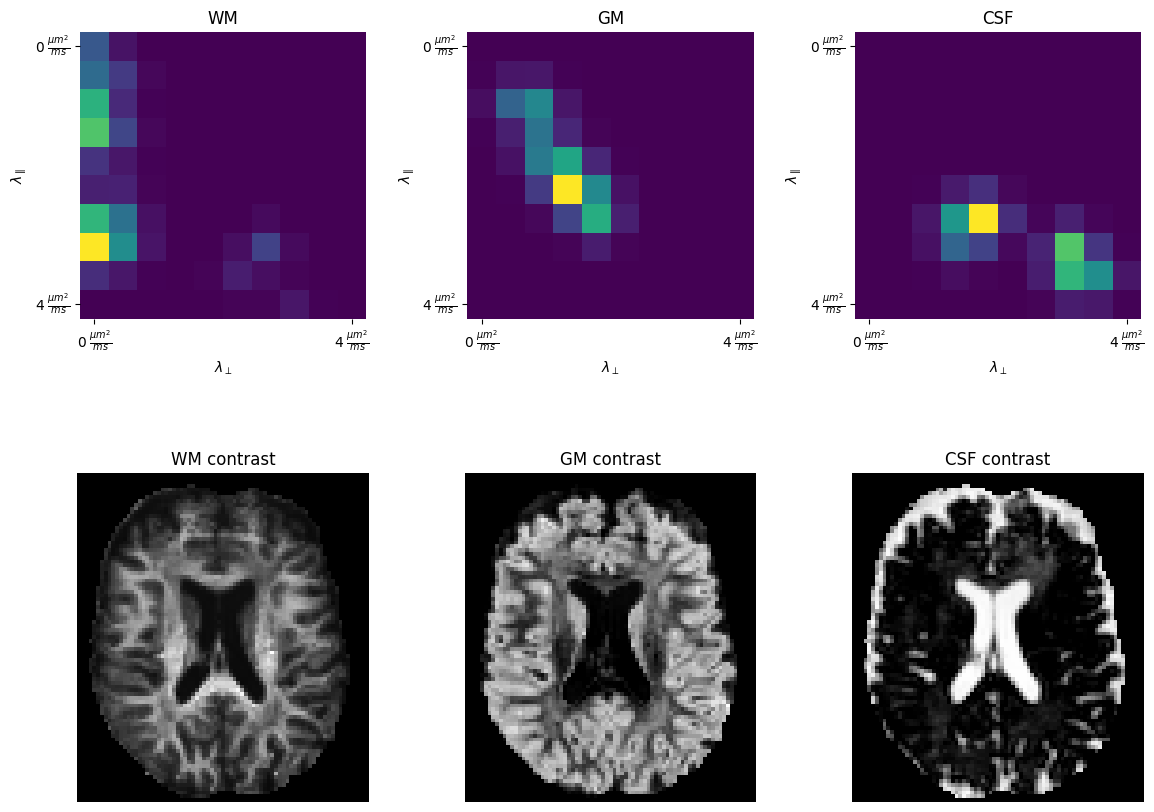

In [11]:
rows = 2
cols = len(tissue_matrices)
fig = plt.figure(figsize=(5*cols, 5*rows))
gs = fig.add_gridspec(rows, cols, hspace=0.5, wspace=0, height_ratios=[1, 1.15])
for i, (matrix, name, contrast) in enumerate(zip(tissue_matrices, tissue_titles, tissue_contrasts)):
    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i])
    sns.heatmap(matrix, cmap='viridis', ax=ax1, square=True, cbar=False)
    sns.heatmap(np.fliplr(np.rot90(contrast[25:-26,25:-16,37])), square=True, cbar=False, cmap='grey', ax=ax2, vmin=0)
    ax1.set_title(name)
    ax2.set_title(f'{name} contrast')
    ax1.set_xlabel(r'$\lambda_\perp$')
    ax1.set_xticks([0.5, len(rd) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'])
    ax1.set_ylabel(r'$\lambda_\parallel$')
    ax1.set_yticks([0.5, len(ad) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'], rotation=0)
    ax2.axis('off')
plt.savefig('/LOCALDATA/sleyse4/tissue.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

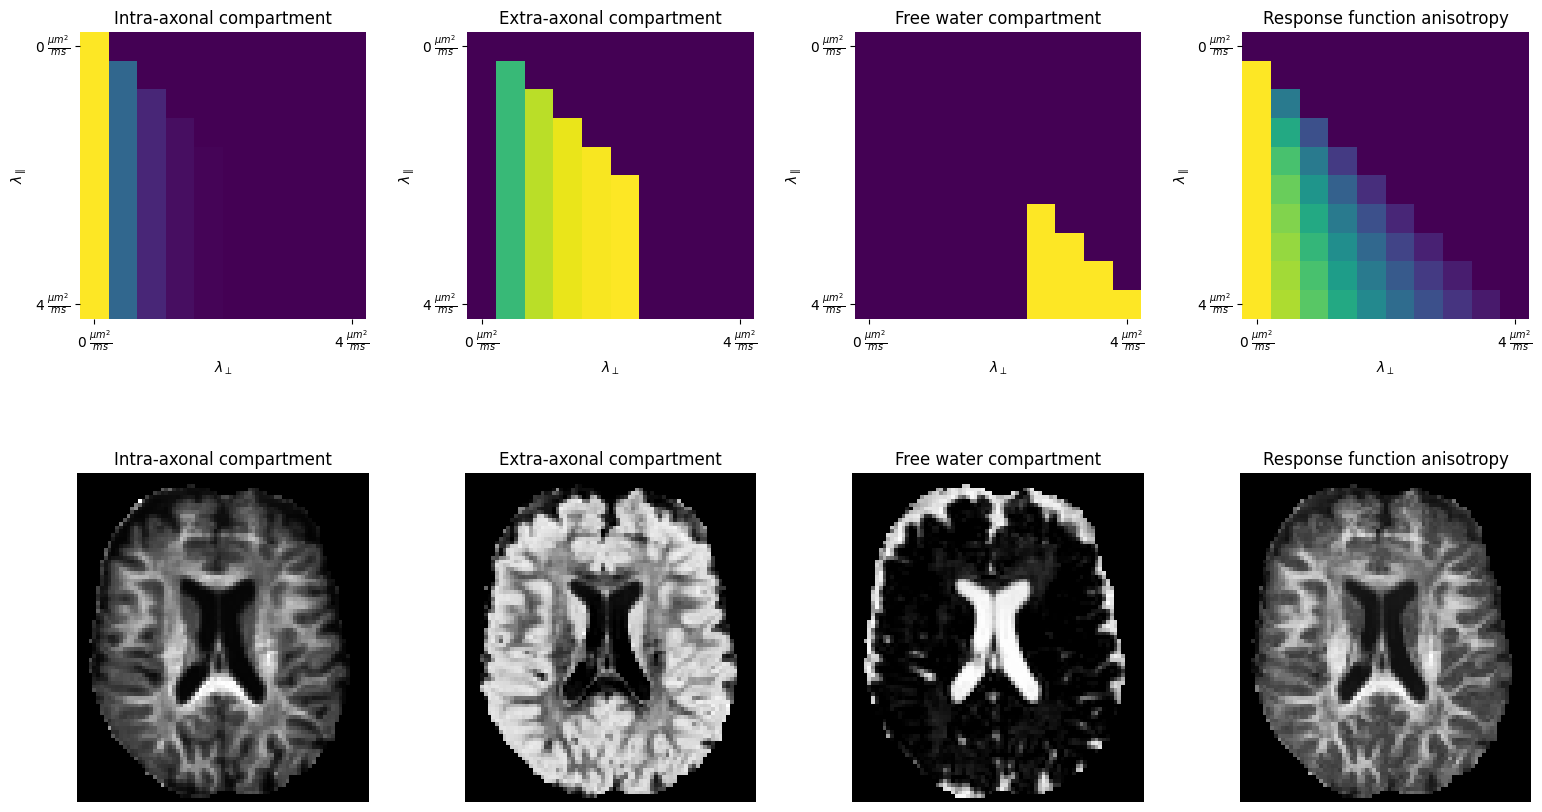

In [12]:

matrices = [iax_matrix, eax_matrix, fw_matrix, fa_matrix]
names = ['Intra-axonal compartment', 'Extra-axonal compartment', 'Free water compartment', 'Response function anisotropy']
contrast_list = [to_contrast(fracs_healthy, matrix) for matrix in matrices]

rows = 2
cols = len(matrices)
fig = plt.figure(figsize=(5*cols, 5*rows))
gs = fig.add_gridspec(rows, cols, hspace=0.5, wspace=0, height_ratios=[1, 1.15])
for i, (matrix, name, contrast) in enumerate(zip(matrices, names, contrast_list)):
    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i])
    sns.heatmap(matrix, cmap='viridis', ax=ax1, square=True, cbar=False)
    sns.heatmap(np.fliplr(np.rot90(contrast[25:-26,25:-16,37])), square=True, cbar=False, cmap='grey', ax=ax2, vmin=0)
    ax1.set_title(name)
    ax2.set_title(f'{name}')
    ax1.set_xlabel(r'$\lambda_\perp$')
    ax1.set_xticks([0.5, len(rd) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'])
    ax1.set_ylabel(r'$\lambda_\parallel$')
    ax1.set_yticks([0.5, len(ad) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'], rotation=0)
    ax2.axis('off')
plt.savefig('/LOCALDATA/sleyse4/contrasts.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

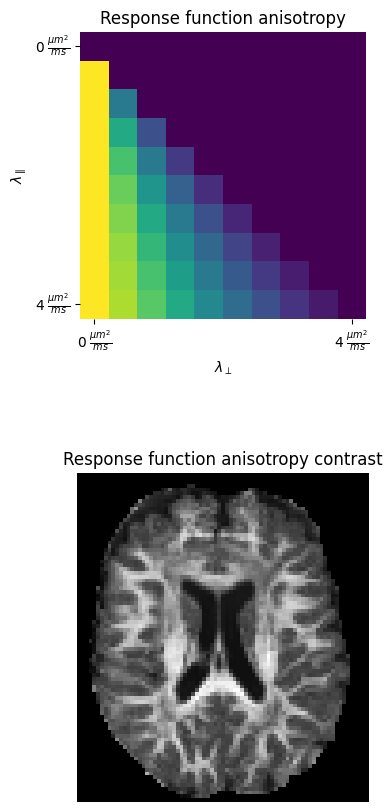

In [13]:
rows = 2
cols = len([fa_matrix])
fig = plt.figure(figsize=(5*cols, 5*rows))
gs = fig.add_gridspec(rows, cols, hspace=0.5, wspace=0, height_ratios=[1, 1.15])
for i, (matrix, name, contrast) in enumerate(zip([fa_matrix], ['Response function anisotropy'], [to_contrast(fracs_healthy, fa_matrix)])):
    ax1 = fig.add_subplot(gs[0, i])
    ax2 = fig.add_subplot(gs[1, i])
    sns.heatmap(matrix, cmap='viridis', ax=ax1, square=True, cbar=False)
    sns.heatmap(np.fliplr(np.rot90(contrast[25:-26,25:-16,37])), square=True, cbar=False, cmap='grey', ax=ax2, vmin=0)
    ax1.set_title(name)
    ax2.set_title(f'{name} contrast')
    ax1.set_xlabel(r'$\lambda_\perp$')
    ax1.set_xticks([0.5, len(rd) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'])
    ax1.set_ylabel(r'$\lambda_\parallel$')
    ax1.set_yticks([0.5, len(ad) - .5], [r'$0 \; \frac{\mu m^2}{ms}$', r'$4 \; \frac{\mu m^2}{ms}$'], rotation=0)
    ax2.axis('off')

plt.savefig('/LOCALDATA/sleyse4/FA.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

In [14]:
def add_noise(noise_free, grad, snr, mask):
    """
    Add Gaussian noise or Rician noise to a signal.

    Returns:
        numpy.ndarray: A signal with added Gaussian/Rician noise.
    """

    mean_b0 = np.mean(noise_free[..., grad[...,-1] == 0][mask])

    std_noise = mean_b0 / snr
    noise1 = np.random.normal(0, std_noise, size=noise_free.shape)
    noise2 = np.random.normal(0, std_noise, size=noise_free.shape)
    noisy_dwi = np.sqrt((noise_free + noise1)**2 + noise2**2)

    return noisy_dwi

def run_lore_sd(dwi, mask, out_dir, gt_odf):
    # Run the LoRE-SD algorithm
    lore_cmd = (
        f'python /home/sleyse4/repos/LoRE_SD/LoRE-SD/dwi2decomposition.py {dwi} '
        f'{out_dir} --cores 100 --mask {mask} '
        f'--eval_matrix /LOCALDATA/sleyse4/Q_odf.npy'
    )
    subprocess.run(lore_cmd, shell=True)
    recon = load_mrtrix(f'{out_dir}/reconstructed.mif').data
    data = load_mrtrix(dwi).data
    rmse = math_utils.rmse(data, recon, load_mrtrix(mask).data > .5)
    acc = sh.angularCorrelation(gt_odf, load_mrtrix(f'{out_dir}/odf.mif').data)
    save_mrtrix(f'{out_dir}/rmse.mif', Image(rmse, vox=load_mrtrix(dwi).vox))
    save_mrtrix(f'{out_dir}/acc.mif', Image(acc, vox=load_mrtrix(dwi).vox))

def run_msmt_csd(dwi, mask, out_dir, gt_odf):
    # Run the MSMT-CSD algorithm
    msmt_cmd = (
        f'dwi2response dhollander {dwi} {out_dir}/wm.txt {out_dir}/gm.txt {out_dir}/csf.txt '
        f'--mask {mask} --force'
    )
    subprocess.run(msmt_cmd, shell=True)

    msmt_cmd = (
        f'dwi2fod msmt_csd {dwi} {out_dir}/wm.txt {out_dir}/wm.mif {out_dir}/gm.txt {out_dir}/gm.mif '
        f'{out_dir}/csf.txt {out_dir}/csf.mif --mask {mask} --predicted_signal {out_dir}/pred.mif --force'
    )
    subprocess.run(msmt_cmd, shell=True)

    recon = load_mrtrix(f'{out_dir}/pred.mif').data
    data = load_mrtrix(dwi).data
    rmse = math_utils.rmse(data, recon, load_mrtrix(mask).data > .5)
    acc = sh.angularCorrelation(gt_odf, load_mrtrix(f'{out_dir}/wm.mif').data)
    save_mrtrix(f'{out_dir}/rmse.mif', Image(rmse, vox=load_mrtrix(dwi).vox))
    save_mrtrix(f'{out_dir}/acc.mif', Image(acc, vox=load_mrtrix(dwi).vox))

In [15]:
READ_DIR = f'/LOCALDATA/sleyse4/simulations/'

snr_dict = {
    'snr10': 10,
    'snr20': 20,
    'snr50': 50,
    'noise_free': np.inf
}

noise_free = load_mrtrix(os.path.join(READ_DIR, 'noise_free.mif')).data
grad = load_mrtrix(os.path.join(READ_DIR, 'noise_free.mif')).grad
wm_mask = load_mrtrix(os.path.join(READ_DIR, 'wm_mask.mif')).data > .5

# for snr_name, snr in snr_dict.items():
#     print(f'Adding noise to {snr_name}')
#     noisy_dwi = add_noise(noise_free, grad, snr, wm_mask)
#     dir = os.path.join(READ_DIR, snr_name)
#     gt_odf = load_mrtrix(os.path.join(READ_DIR, 'gt_odf.mif')).data
#     if not os.path.exists(dir):
#         os.makedirs(dir)
#     print(f'Saving {snr_name}')
#     save_mrtrix(os.path.join(dir, f'{snr_name}.mif'), Image(noisy_dwi, vox=vox, grad=grad))

#     lore_dir = os.path.join(dir, 'LoRE')
#     if not os.path.exists(lore_dir):
#         os.makedirs(lore_dir)

#     print(f'Running LoRE-SD on {snr_name}')
#     run_lore_sd(os.path.join(dir, f'{snr_name}.mif'), os.path.join(READ_DIR, 'mask.mif'), lore_dir, gt_odf)
#     print(f'Running MSMT-CSD')
#     msmt_dir = os.path.join(dir, 'MTCSD')
#     if not os.path.exists(msmt_dir):
#         os.makedirs(msmt_dir)
#     run_msmt_csd(os.path.join(dir, f'{snr_name}.mif'), os.path.join(READ_DIR, 'mask.mif'), msmt_dir, gt_odf)
    
    

In [16]:
# for row, (snr_str, snr) in enumerate(snr_dict.items()):
#     pred_msmt = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'pred.mif')).data
#     noisy = load_mrtrix(os.path.join(READ_DIR, snr_str, f'{snr_str}.mif')).data
#     mask = load_mrtrix(os.path.join(READ_DIR, 'mask.mif')).data > .5
#     rmse = math_utils.rmse(pred_msmt, noise_free, mask)
#     save_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'rmse.mif'), Image(rmse, vox=vox))

(1065, 3168, 4)


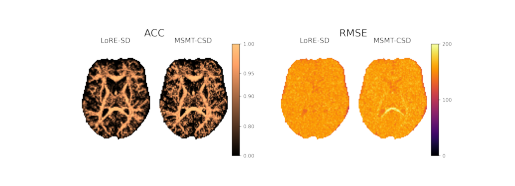

In [17]:
from matplotlib.colors import PowerNorm
import matplotlib.image as mpimg

noise_free = load_mrtrix(os.path.join(READ_DIR, 'noise_free.mif')).data

x_min, x_max = 25, -25
y_min, y_max = 20, -20
SLICE_IDX = 33

sub_dict = {
    # 'snr10': 10,
    'snr20': 20,
    # 'snr50': 50,
    # 'noise_free': np.inf
}

mask = (load_mrtrix(os.path.join(READ_DIR, 'mask.mif')).data > .5)[x_min:x_max,y_min:y_max,SLICE_IDX]

methods = ['LORE', 'MTCSD']
fig = plt.figure(figsize=(10, 4))

# Create separate GridSpec objects for acc and rmse
gs_acc = fig.add_gridspec(len(sub_dict), 3, left=0, right=0.45, width_ratios=[1,1,.1], wspace=0, hspace=0)
gs_rmse = fig.add_gridspec(len(sub_dict), 3, left=0.55, right=1, width_ratios=[1,1,.1], wspace=0, hspace=0)


for row, (snr_str, snr) in enumerate(sub_dict.items()):
    ax_acc_LORE = fig.add_subplot(gs_acc[row, 0])
    acc_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LoRE', 'acc.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_acc_LORE.imshow(np.rot90(acc_LORE), cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=6), alpha=np.rot90(mask).astype(float))
    ax_acc_LORE.axis('off')

    acc_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'acc.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_acc_MTCSD = fig.add_subplot(gs_acc[row, 1])
    im_acc = ax_acc_MTCSD.imshow(np.rot90(acc_MTCSD), cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=6), alpha=np.rot90(mask).astype(float))
    ax_acc_MTCSD.axis('off')

    ax_res_LORE = fig.add_subplot(gs_rmse[row, 0])
    res_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LoRE', 'rmse.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    ax_res_LORE.imshow(np.rot90(res_LORE), cmap='inferno', alpha=np.rot90(mask).astype(float), vmin=0, vmax=200)
    ax_res_LORE.axis('off')

    ax_res_MTCSD = fig.add_subplot(gs_rmse[row, 1])
    res_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'rmse.mif')).data[x_min:x_max,y_min:y_max,SLICE_IDX]
    im_res = ax_res_MTCSD.imshow(np.rot90(res_MTCSD), cmap='inferno', alpha=np.rot90(mask).astype(float), vmin=0, vmax=200)
    ax_res_MTCSD.axis('off')

ax_cbar_acc = fig.add_subplot(gs_acc[:, -1])
cbar_acc = plt.colorbar(im_acc, cax=ax_cbar_acc)
cbar_acc.ax.set_yticks([0, 0.8, 0.9, 0.95, 1])

ax_cbar_res = fig.add_subplot(gs_rmse[:, -1])
cbar_res = plt.colorbar(im_res, cax=ax_cbar_res)
cbar_res.ax.set_yticks([0, 100, 200])

middle_acc = ax_acc_LORE.get_position().x0 + (ax_acc_MTCSD.get_position().x1 - ax_acc_LORE.get_position().x0) / 2
fig.text(middle_acc, .95, 'ACC', ha='center', va='center', fontsize=20)

middle_res = ax_res_LORE.get_position().x0 + (ax_res_MTCSD.get_position().x1 - ax_res_LORE.get_position().x0) / 2
fig.text(middle_res, .95, 'RMSE', ha='center', va='center', fontsize=20)

middle_acc_LORE = ax_acc_LORE.get_position().x0 + (ax_acc_LORE.get_position().x1 - ax_acc_LORE.get_position().x0) / 2
fig.text(middle_acc_LORE, .9, 'LoRE-SD', ha='center', va='center', fontsize=14)

middle_acc_MTCSD = ax_acc_MTCSD.get_position().x0 + (ax_acc_MTCSD.get_position().x1 - ax_acc_MTCSD.get_position().x0) / 2
fig.text(middle_acc_MTCSD, .9, 'MSMT-CSD', ha='center', va='center', fontsize=14)

middle_res_LORE = ax_res_LORE.get_position().x0 + (ax_res_LORE.get_position().x1 - ax_res_LORE.get_position().x0) / 2
fig.text(middle_res_LORE, .9, 'LoRE-SD', ha='center', va='center', fontsize=14)

middle_res_MTCSD = ax_res_MTCSD.get_position().x0 + (ax_res_MTCSD.get_position().x1 - ax_res_MTCSD.get_position().x0) / 2
fig.text(middle_res_MTCSD, .9, 'MSMT-CSD', ha='center', va='center', fontsize=14)

fig.savefig('/LOCALDATA/sleyse4/full_brain_sim.png', dpi=300, transparent=True, bbox_inches='tight')
plt.close(fig)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/full_brain_sim.png')
# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]


new_fig_size = (img.shape[1]/300, (bottom_white-top_white+1)/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[top_white:bottom_white])
plt.axis('off')

plt.savefig('/LOCALDATA/sleyse4/full_brain_sim.png', dpi=300, transparent=True, bbox_inches=0)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/full_brain_sim.png')
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()


In [18]:
from matplotlib.pyplot import setp

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='orange')
    setp(bp['caps'][2], color='orange')
    setp(bp['caps'][3], color='orange')
    setp(bp['whiskers'][2], color='orange')
    setp(bp['whiskers'][3], color='orange')
    setp(bp['medians'][1], color='orange')

    try:
        setp(bp['boxes'][2], color='green')
        setp(bp['caps'][4], color='green')
        setp(bp['caps'][5], color='green')
        setp(bp['whiskers'][4], color='green')
        setp(bp['whiskers'][5], color='green')
        setp(bp['medians'][2], color='green')
    except:
        pass

(1701, 3168)


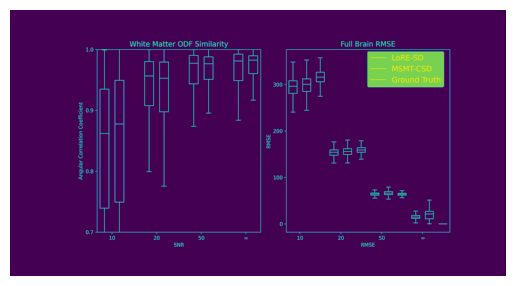

In [52]:
from matplotlib.colors import PowerNorm
import matplotlib.image as mpimg
from scipy.ndimage import binary_erosion


READ_DIR = f'/LOCALDATA/sleyse4/simulations/'

snr_dict = {
    'snr10': 10,
    'snr20': 20,
    'snr50': 50,
    'noise_free': np.inf
}

x_min, x_max = 25, -25
y_min, y_max = 20, -20
SLICE_IDX = 33

mask = (load_mrtrix(os.path.join(READ_DIR, 'mask.mif')).data > .5)
wm_mask = (load_mrtrix(os.path.join(READ_DIR, 'wm_mask.mif')).data > .5)

fig, axs = plt.subplots(1, 2, figsize=(3168/300, 6))

for row, (snr_str, snr) in enumerate(snr_dict.items()):
    acc_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LoRE', 'acc.mif')).data[wm_mask]

    acc_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'acc.mif')).data[wm_mask]

    res_LORE = load_mrtrix(os.path.join(READ_DIR, snr_str, 'LoRE', 'rmse.mif')).data[mask]

    res_MTCSD = load_mrtrix(os.path.join(READ_DIR, snr_str, 'MTCSD', 'rmse.mif')).data[mask]

    gt_rmse = load_mrtrix(os.path.join(READ_DIR, snr_str, 'gt_rmse.mif')).data[mask]

    bp_acc = axs[0].boxplot(
            [acc_LORE, acc_MTCSD],
            positions=[1 + 3 * row, 2 + 3 * row],
            widths=0.6,
            showfliers=False
        )
    setBoxColors(bp_acc)

    bp_res = axs[1].boxplot(
            [res_LORE, res_MTCSD, gt_rmse],
            positions=[1 + 3 * row, 2 + 3 * row, 3+3 * row],
            widths=0.6,
            showfliers=False
        )
    setBoxColors(bp_res)

axs[0].set_xticks([1.5 + 3 * i for i in range(len(snr_dict))])
axs[0].set_xticklabels([rf'${v}$' if v != np.inf else r'$\infty$' for v in snr_dict.values()])
axs[0].set_xlabel('SNR')
axs[0].set_ylim(0.7, 1)
axs[0].set_title('White Matter ODF Similarity', fontsize=14)
if axs[0] != axs.T[0]:
    axs[0].set_yticklabels([])
else:
    axs[0].set_yticks([.7, .8, .9, 1])

axs[0].set_ylabel('Angular Correlation Coefficient')

axs[1].set_xticks([1.5 + 3 * i for i in range(len(snr_dict))])
axs[1].set_xticklabels([rf'${v}$' if v != np.inf else r'$\infty$' for v in snr_dict.values()])
axs[1].set_xlabel('RMSE')
axs[1].set_yticks([0, 100, 200, 300])
axs[1].set_title('Full Brain RMSE', fontsize=14)
if axs[1] != axs.T[1]:
    axs[1].set_yticklabels([])

axs[1].set_ylabel('RMSE')

# Add a legend below the figure
fig.legend([bp_res['boxes'][0], bp_res['boxes'][1], bp_res['boxes'][2]], ['LoRE-SD', 'MSMT-CSD', 'Ground Truth'], 
           ncol=1, fontsize=15, loc='center right', bbox_to_anchor=(.98, .845), frameon=True)

fig.tight_layout()
fig.savefig('/LOCALDATA/sleyse4/full_brain_boxplots.png', dpi=300, transparent=True, bbox_inches=0)
plt.close()

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/full_brain_boxplots.png')

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = (img.shape[1]/300, (bottom_white-top_white+1)/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[top_white:bottom_white,:])
plt.axis('off')

plt.savefig('/LOCALDATA/sleyse4/full_brain_boxplots.png', dpi=300, transparent=True, bbox_inches=0)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/full_brain_boxplots.png')[...,-1]
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()



[(1065, 3168, 4), (1701, 3168, 4)]
(2261, 2395, 4)


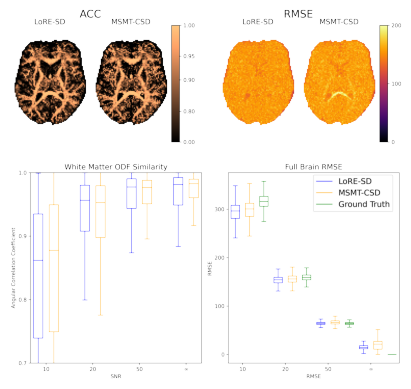

In [20]:
# Read all images and stitch them together horizontally with 500px padding
slice = mpimg.imread('/LOCALDATA/sleyse4/full_brain_sim.png')
boxplots = mpimg.imread('/LOCALDATA/sleyse4/full_brain_boxplots.png')

max_width = max([img.shape[1] for img in [slice, boxplots]])
min_width = min([img.shape[1] for img in [slice, boxplots]])

print([img.shape for img in [slice, boxplots]])

assert max_width == min_width, f'Images have different widths ({max_width} vs {min_width})'

padding_width = 0
padding = np.ones((padding_width, max_width, 4), dtype=np.uint8)
padding[..., -1] = 0

# Concatenate images with padding
stitched_image = np.concatenate((slice[:-100], padding, boxplots[100:]), axis=0)

left_white = np.where(np.any(stitched_image[...,-1] != 0, axis=0))[0][0]-5
right_white = np.where(np.any(stitched_image[...,-1] != 0, axis=0))[0][-1]+5
top_white = np.where(np.any(stitched_image[...,-1] != 0, axis=1))[0][0]-5
bottom_white = np.where(np.any(stitched_image[...,-1] != 0, axis=1))[0][-1]+5

# Save the stitched image
mpimg.imsave('/LOCALDATA/sleyse4/sim_concat.png', stitched_image[top_white:bottom_white+1, left_white:right_white+1])

# Display the stitched image
import matplotlib.pyplot as plt
plt.imshow(mpimg.imread('/LOCALDATA/sleyse4/sim_concat.png'))
print(mpimg.imread('/LOCALDATA/sleyse4/sim_concat.png').shape)
plt.axis('off')
plt.show()

In [21]:
import pandas as pd


# GLIOMA_DIR = '/LOCALDATA/sleyse4//'
DATA_DIR = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/'
ORIG_DIR = '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/'

# Find all subdirectories with sub-PTXXX
subjects = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d)) and d.startswith('sub-PT') and '21' not in d]

data = []

for i, subject in enumerate(subjects):
    preproc_dir = os.path.join(DATA_DIR, subject)
    lore_dir = os.path.join(DATA_DIR, subject, 'LoRE')
    mtcsd_dir = os.path.join(DATA_DIR, subject, 'MTCSD')

    acc = load_mrtrix(os.path.join(DATA_DIR, subject, 'acc.mif')).data
    wm_seg = load_mrtrix(os.path.join(preproc_dir, '5tt_regrid.mif')).data[...,2] > .95

    lesion = load_mrtrix(os.path.join(preproc_dir, 'lesion_regrid.mif')).data > .5
    
    mask = load_mrtrix(os.path.join(ORIG_DIR, subject, 'PREPROC/mask.mif')).data > .5
    # Healthy mask is the mask without the lesion
    healthy_mask = np.logical_xor(mask, lesion)

    wm_acc = acc[wm_seg]
    lore_healthy = load_mrtrix(os.path.join(lore_dir, 'rmse.mif')).data[healthy_mask]
    lore_glioma = load_mrtrix(os.path.join(lore_dir, 'rmse.mif')).data[lesion]
    mtcsd_healthy = load_mrtrix(os.path.join(mtcsd_dir, 'rmse.mif')).data[healthy_mask]
    mtcsd_glioma = load_mrtrix(os.path.join(mtcsd_dir, 'rmse.mif')).data[lesion]

    # Remove nan values
    wm_acc = wm_acc[~np.isnan(wm_acc)]
    lore_healthy = lore_healthy[~np.isnan(lore_healthy)]
    lore_glioma = lore_glioma[~np.isnan(lore_glioma)]
    mtcsd_healthy = mtcsd_healthy[~np.isnan(mtcsd_healthy)]
    mtcsd_glioma = mtcsd_glioma[~np.isnan(mtcsd_glioma)]
    
    data += [(subject, wm_acc.mean(), lore_healthy.mean(), lore_glioma.mean(), mtcsd_healthy.mean(), mtcsd_glioma.mean())]
df = pd.DataFrame(data=data, columns=['Subject', 'ACC', 'RMSE LoRE (Healthy)', 'RMSE LoRE (Glioma)', 'RMSE MSMT-CSD (Healthy)', 'RMSE MSMT-CSD (Glioma)'])

# Calculate the percentage increase
df['LoRE-SD Increase (%)'] = ((df['RMSE LoRE (Glioma)'] - df['RMSE LoRE (Healthy)']) / df['RMSE LoRE (Healthy)']) * 100
df['MSMT-CSD Increase (%)'] = ((df['RMSE MSMT-CSD (Glioma)'] - df['RMSE MSMT-CSD (Healthy)']) / df['RMSE MSMT-CSD (Healthy)']) * 100

# Create a new DataFrame for the percentage increases
df_increase = df[['Subject', 'LoRE-SD Increase (%)', 'MSMT-CSD Increase (%)']]
df_increase.set_index('Subject', inplace=True)

Text(0.5, 1.0, 'RMSE in Healthy and Glioma Tissues')

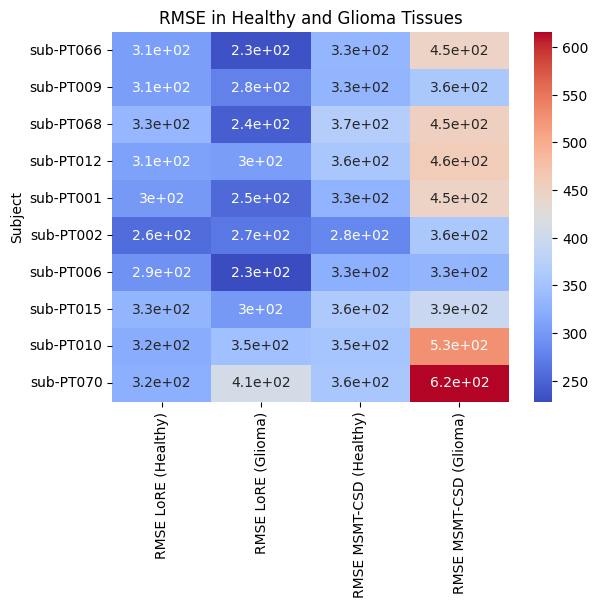

In [22]:
# Heatmap
fig, ax = plt.subplots()
sns.heatmap(df.drop(columns=['ACC', 'LoRE-SD Increase (%)', 'MSMT-CSD Increase (%)']).set_index('Subject'), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('RMSE in Healthy and Glioma Tissues')

In [23]:
print(f'Mean increase LoRE-SD: {df_increase["LoRE-SD Increase (%)"].mean():.2f}')
print(f'Mean increase MSM-CSD: {df_increase["MSMT-CSD Increase (%)"].mean():.2f}')

Mean increase LoRE-SD: -7.07
Mean increase MSM-CSD: 28.90


In [24]:
low_grade_subjects = [f'sub-PT{i:03d}' for i in [1, 10, 15, 66, 70]]
high_grade_subjects = [f'sub-PT{i:03d}' for i in [2, 6, 9, 12, 68]]
low_grade_df = df[df['Subject'].isin(low_grade_subjects)]
high_grade_df = df[df['Subject'].isin(high_grade_subjects)]

# Add a new column for the grade
low_grade_df['Grade'] = 'Low Grade'
high_grade_df['Grade'] = 'High Grade'

low_grade_df.set_index('Grade', inplace=True)
high_grade_df.set_index('Grade', inplace=True)

print(f'Mean increase LoRE-SD low grade: {low_grade_df["LoRE-SD Increase (%)"].mean():.2f}')
print(f'Mean increase MT-CSD low grade: {low_grade_df["MSMT-CSD Increase (%)"].mean():.2f}')
print(f'Mean increase LoRE-SD high grade: {high_grade_df["LoRE-SD Increase (%)"].mean():.2f}')
print(f'Mean increase MT-CSD high grade: {high_grade_df["MSMT-CSD Increase (%)"].mean():.2f}')

Mean increase LoRE-SD low grade: -2.96
Mean increase MT-CSD low grade: 39.83
Mean increase LoRE-SD high grade: -11.17
Mean increase MT-CSD high grade: 17.97


/tmp/ipykernel_4151698/1598173847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_grade_df['Grade'] = 'Low Grade'
/tmp/ipykernel_4151698/1598173847.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_grade_df['Grade'] = 'High Grade'


In [25]:
def rotate_point(x, y, angle_rad):
    cos,sin = np.cos(angle_rad),np.sin(angle_rad)
    return cos*x-sin*y,sin*x+cos*y

def draw_brace(ax, span, position, text, text_pos, brace_scale=1.0, beta_scale=300., rotate=False, rotate_text=False):
    '''
        all positions and sizes are in axes units
        span: size of the curl
        position: placement of the tip of the curl
        text: label to place somewhere
        text_pos: position for the label
        beta_scale: scaling for the curl, higher makes a smaller radius
        rotate: true rotates to place the curl vertically
        rotate_text: true rotates the text vertically        
    '''
    # get the total width to help scale the figure
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    resolution = int(span/xax_span*100)*2+1 # guaranteed uneven
    beta = beta_scale/xax_span # the higher this is, the smaller the radius
    # center the shape at (0, 0)
    x = np.linspace(-span/2., span/2., resolution)
    # calculate the shape
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    # put the tip of the curl at (0, 0)
    max_y = np.max(y)    
    min_y = np.min(y)
    y /= (max_y-min_y)
    y *= brace_scale
    y -= max_y
    # rotate the trace before shifting
    if rotate:
        x,y = rotate_point(x, y, np.pi/2)
    # shift to the user's spot   
    x += position[0]        
    y += position[1]
    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1, clip_on=False)
    # put the text
    ax.text(text_pos[0], text_pos[1], text, ha='center', va='bottom', rotation=90 if rotate_text else 0) 

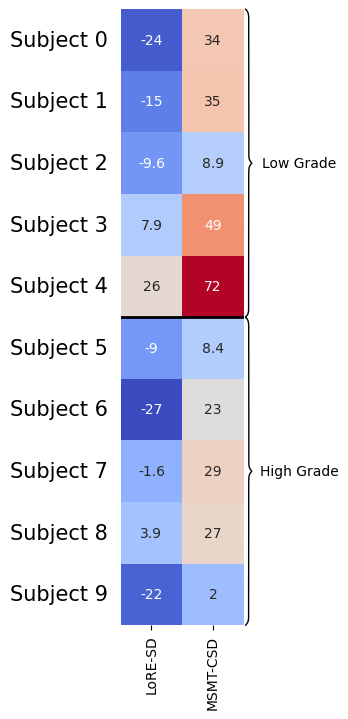

In [26]:
# Annotated Heatmap for percentage increase

graded_df = pd.concat([low_grade_df, high_grade_df])

fig, ax = plt.subplots(figsize=(2,8))
sns.heatmap(graded_df.loc[:,['LoRE-SD Increase (%)', 'MSMT-CSD Increase (%)']], annot=True, cmap='coolwarm', ax=ax, cbar=False)
# ax.set_title('RMSE increase in glioma', pad=20)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticklabels(['LoRE-SD', 'MSMT-CSD'])

# Draw brackets and labels
draw_brace(ax, 5, [.48,2.5], 'Low Grade', (2.9,2.62), rotate=True, brace_scale=-0.1, beta_scale=70)
# Draw brackets and labels
draw_brace(ax, 5, [.48,7.5], 'High Grade', (2.9,7.62), rotate=True, brace_scale=-0.1, beta_scale=70)

for i in range(len(graded_df)):
    ax.text(-1, i+.5, f'Subject {i}', ha='center', va='center', fontsize=15)

# Add a horizontal line
ax.axhline(5, color='black', lw=2)

plt.savefig('/LOCALDATA/sleyse4/heatmap_full.png', dpi=300, bbox_inches=Bbox([[-1.5,0],[5,8]]), transparent=True)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/heatmap_full.png')

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = ((right_white-left_white)/300, img.shape[0]/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[:,left_white:right_white])
plt.axis('off')

plt.text(.5, 1, 'RMSE increase in glioma (%)', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.savefig('/LOCALDATA/sleyse4/heatmap.png', dpi=300, transparent=True)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/heatmap.png')
plt.imshow(img)


In [27]:
def prep_image(img, mask, idx, lesion=None):
    img_slice = img[:,:,idx]
    mask_slice= mask[:,:,idx]
    lesion_slice = lesion[:,:,idx] if lesion is not None else None

    mask_idx = np.where(mask_slice)
    left, right = np.min(mask_idx[1])-3, np.max(mask_idx[1])+3
    top, bottom = np.min(mask_idx[0])-3, np.max(mask_idx[0])+3

    img_sub = img_slice[top:bottom, left:right]
    mask_sub = mask_slice[top:bottom, left:right]
    lesion_sub = lesion_slice[top:bottom, left:right] if lesion is not None else None

    img_rot = np.fliplr(np.rot90(img_sub))
    mask_rot = np.fliplr(np.rot90(mask_sub))
    lesion_rot = np.fliplr(np.rot90(lesion_sub)) if lesion is not None else None

    return img_rot, mask_rot, lesion_rot
    

In [28]:

# Define the colors
colors = ["orange", "blue"]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("orange_blue", colors)


data_dict = {
    'Healthy': ('/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/philips', None, 40),
    'Low Grade': ( '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT010/', '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT010/', 35),
    'High Grade': ( '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/Blind_Deconvolution/Preprocessing/sub-PT012/', '/DATASERVER/MIC/GENERAL/STAFF/sleyse4/u0152170/DATA/glioma/sub-PT012/', 35)
}

fig = plt.figure(figsize=(3,8))
gs_acc = fig.add_gridspec(3, 2, width_ratios=[1,.1])

for dataset, (dir_out, dir_in, slice) in data_dict.items():
    mask = load_mrtrix(os.path.join(dir_out, 'mask.mif')).data > .5
    if dir_in is not None:
        lesion = load_mrtrix(os.path.join(dir_in, 'LESION/lesion_regrid.mif')).data > .5
    else:
        lesion = None
    acc = load_mrtrix(os.path.join(dir_out, 'acc.mif')).data
    rmse_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/rmse.mif')).data
    rmse_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/rmse.mif')).data
    aic_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/aic.mif')).data
    aic_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/aic.mif')).data

    acc_slice, mask_slice, lesion_slice = prep_image(acc, mask, slice, lesion)
    rmse_lore_slice, _, _ = prep_image(rmse_lore, mask, slice)
    rmse_mtcsd_slice, _, _ = prep_image(rmse_mtcsd, mask, slice)
    aic_lore_slice, _, _ = prep_image(aic_lore, mask, slice)
    aic_mtcsd_slice, _, _ = prep_image(aic_mtcsd, mask, slice)

    row = list(data_dict.keys()).index(dataset)

    ax_acc = fig.add_subplot(gs_acc[row, 0])
    ax_acc.set_ylabel(dataset, fontsize=20)
    im_acc = ax_acc.imshow(acc_slice, cmap='copper', norm=PowerNorm(vmin=0, vmax=1, gamma=6), alpha=mask_slice.astype(float))
    if lesion is not None:
        ax_acc.contour(lesion_slice, colors='red', levels=[0.5])
    # Remove ticks and frame
    ax_acc.set_xticks([])
    ax_acc.set_yticks([])
    ax_acc.spines['top'].set_visible(False)
    ax_acc.spines['right'].set_visible(False)
    ax_acc.spines['bottom'].set_visible(False)
    ax_acc.spines['left'].set_visible(False)

acc_cbar = fig.add_subplot(gs_acc[:, -1])
cbar_acc = plt.colorbar(im_acc, cax=acc_cbar)
cbar_acc.ax.set_yticks([0, 0.8, 0.9, 0.95, 1])

plt.savefig('/LOCALDATA/sleyse4/acc.png', dpi=300, transparent=True, bbox_inches=Bbox([[0,0],[5,8]]))
plt.close(fig)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/acc.png')
print(img.shape)

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = ((right_white-left_white)/300, img.shape[0]/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[:,left_white:right_white])
plt.axis('off')

plt.text(0.5, 1, 'ACC', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.savefig('/LOCALDATA/sleyse4/acc.png', dpi=300, transparent=True)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/acc.png')
print(img.shape)

(2400, 1500, 4)
(2400, 850, 4)


In [29]:

# Define the colors
colors = ["orange", "blue"]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("orange_blue", colors)


fig = plt.figure(figsize=(5,8))
gs_rmse = fig.add_gridspec(3, 2, width_ratios=[1,1])

for dataset, (dir_out, dir_in, slice) in data_dict.items():
    mask = load_mrtrix(os.path.join(dir_out, 'mask.mif')).data > .5
    if dir_in is not None:
        lesion = load_mrtrix(os.path.join(dir_in, 'LESION/lesion_regrid.mif')).data > .5
    else:
        lesion = None
    
    rmse_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/rmse.mif')).data
    rmse_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/rmse.mif')).data
    aic_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/aic.mif')).data
    aic_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/aic.mif')).data

    rmse_lore_slice, mask_slice, lesion_slice = prep_image(rmse_lore, mask, slice, lesion)
    rmse_mtcsd_slice, _, _ = prep_image(rmse_mtcsd, mask, slice)
    aic_lore_slice, _, _ = prep_image(aic_lore, mask, slice)
    aic_mtcsd_slice, _, _ = prep_image(aic_mtcsd, mask, slice)

    row = list(data_dict.keys()).index(dataset)

    # Get the min and max value of this img
    vmin, vmax = np.nanmin(rmse_lore_slice), np.nanmax(rmse_mtcsd_slice)

    ax_rmse_lore = fig.add_subplot(gs_rmse[row, 0])
    im_rmse_lore = ax_rmse_lore.imshow(rmse_lore_slice, cmap='inferno', alpha=mask_slice.astype(float), vmin=vmin, vmax=vmax)
    
    ax_rmse_lore.axis('off')
    if lesion is not None:
        ax_rmse_lore.contour(lesion_slice, colors='red', levels=[0.5])

    ax_rmse_mtcsd = fig.add_subplot(gs_rmse[row, 1])
    im_rmse_mtcsd = ax_rmse_mtcsd.imshow(rmse_mtcsd_slice, cmap='inferno', alpha=mask_slice.astype(float), vmin=vmin, vmax=vmax)
    if lesion is not None:
        ax_rmse_mtcsd.contour(lesion_slice, colors='red', levels=[0.5])
    ax_rmse_mtcsd.axis('off')

plt.savefig('/LOCALDATA/sleyse4/rmse.png', dpi=300, transparent=True, bbox_inches=Bbox([[0,0],[5,8]]))
plt.close(fig)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/rmse.png')

print(img.shape)

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = ((right_white-left_white)/300, img.shape[0]/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[:,left_white:right_white])
plt.axis('off')

plt.text(0.5, 1, 'RMSE', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.text(0.2, .95, 'LoRE-SD', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)
plt.text(0.8, .95, 'MSMT-CSD', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.savefig('/LOCALDATA/sleyse4/rmse.png', dpi=300, transparent=True)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/rmse.png')
print(img.shape)

(2400, 1500, 4)
(2400, 1063, 4)


In [30]:

# Define the colors
colors = ["orange", "white", "blue"]

# Create the colormap
cmap = LinearSegmentedColormap.from_list("orange_blue", colors)


fig = plt.figure(figsize=(5,8))
gs_aic = fig.add_gridspec(3, 2, width_ratios=[1,1])

for dataset, (dir_out, dir_in, slice) in data_dict.items():
    mask = load_mrtrix(os.path.join(dir_out, 'mask.mif')).data > .5
    if dir_in is not None:
        lesion = load_mrtrix(os.path.join(dir_in, 'LESION/lesion_regrid.mif')).data > .5
    else:
        lesion = None
    
    aic_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/aic.mif')).data
    aic_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/aic.mif')).data

    aic_lore_slice, mask_slice, lesion_slice = prep_image(aic_lore, mask, slice, lesion)
    aic_mtcsd_slice, _, _ = prep_image(aic_mtcsd, mask, slice, lesion)

    row = list(data_dict.keys()).index(dataset)

    mean, std = np.mean(aic_lore_slice), np.std(aic_lore_slice)
    vmin, vmax = mean - .5*std, mean + std

    ax_aic_lore = fig.add_subplot(gs_aic[row, 0])
    im_aic_lore = ax_aic_lore.imshow(aic_lore_slice, cmap='inferno', alpha=mask_slice.astype(float), vmin=vmin, vmax=vmax)
    ax_aic_lore.axis('off')
    if lesion is not None:
        ax_aic_lore.contour(lesion_slice, colors='red', levels=[0.5])

    ax_aic_mtcsd = fig.add_subplot(gs_aic[row, 1])
    im_aic_mtcsd = ax_aic_mtcsd.imshow(aic_mtcsd_slice, cmap='inferno', alpha=mask_slice.astype(float), vmin=vmin, vmax=vmax)
    if lesion is not None:
        ax_aic_mtcsd.contour(lesion_slice, colors='red', levels=[0.5])
    ax_aic_mtcsd.axis('off')

plt.savefig('/LOCALDATA/sleyse4/aic.png', dpi=300, transparent=True, bbox_inches=Bbox([[0,0],[5,8]]))
plt.close(fig)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/aic.png')

print(img.shape)

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = ((right_white-left_white)/300, img.shape[0]/300)
plt.figure(figsize=new_fig_size)
plt.imshow(img[:,left_white:right_white])
plt.axis('off')

plt.text(0.5, 1, 'AIC', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.text(0.2, .95, 'LoRE-SD', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)
plt.text(0.8, .95, 'MSMT-CSD', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.savefig('/LOCALDATA/sleyse4/aic.png', dpi=300, transparent=True)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/aic.png')
print(img.shape)

(2400, 1500, 4)
(2400, 1063, 4)


In [31]:
# Define the colors
colors = ["orange", "blue"]

# Create the colormap
cmap = LinearSegmentedColormap.from_list('AIC_Gradient_CMap', (
    (0.000, (0, 0, 1, 1)),
    (0.500, (1, 1, 1, 1)),
    (1.000, (1, .5, 0, 1))))

fig = plt.figure(figsize=(3,8))
gs_acc = fig.add_gridspec(3, 2, width_ratios=[1,.1])

for dataset, (dir_out, dir_in, slice) in data_dict.items():
    mask = load_mrtrix(os.path.join(dir_out, 'mask.mif')).data > .5
    if dir_in is not None:
        lesion = load_mrtrix(os.path.join(dir_in, 'LESION/lesion_regrid.mif')).data > .5
    else:
        lesion = None
    aic_lore = load_mrtrix(os.path.join(dir_out, 'LoRE/aic.mif')).data
    aic_mtcsd = load_mrtrix(os.path.join(dir_out, 'MTCSD/aic.mif')).data

    aic_lore_slice, mask_slice, lesion_slice = prep_image(aic_lore, mask, slice, lesion)
    aic_mtcsd_slice, _, _ = prep_image(aic_mtcsd, mask, slice)

    diff = aic_lore_slice - aic_mtcsd_slice

    row = list(data_dict.keys()).index(dataset)

    ax_acc = fig.add_subplot(gs_acc[row, 0])
    im_acc = ax_acc.imshow(diff, cmap=cmap, alpha=mask_slice.astype(float), vmin=-300, vmax=300)
    if lesion is not None:
        ax_acc.contour(lesion_slice, colors='red', levels=[0.5])
    ax_acc.axis('off')
    ax_acc.set_ylabel(dataset)

acc_cbar = fig.add_subplot(gs_acc[:, -1])
cbar_acc = plt.colorbar(im_acc, cax=acc_cbar)
cbar_acc.ax.set_yticks([-300, 300], ['LoRE-SD', 'MSMT-CSD'])

plt.savefig('/LOCALDATA/sleyse4/selection.png', dpi=300, transparent=True, bbox_inches=Bbox([[0,0],[5,8]]))
plt.close(fig)

# Load and display the image
img = mpimg.imread('/LOCALDATA/sleyse4/selection.png')

print(img.shape)

# Remove left, right and bottom white space
left_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][0]
right_white = np.where(np.any(img[...,-1] != 0, axis=0))[0][-1]
top_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][0]
bottom_white = np.where(np.any(img[...,-1] != 0, axis=1))[0][-1]

new_fig_size = ((right_white-left_white)/300, img.shape[0]/300)
plt.figure(figsize=new_fig_size)

plt.imshow(img[:,left_white:right_white])
plt.axis('off')

plt.text(0.5, 1, r'Preferred Model', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)
plt.text(0.5, .95, r'($\Delta_{AIC}$)', ha='center', va='center', fontsize=15, transform=plt.gca().transAxes)

plt.savefig('/LOCALDATA/sleyse4/selection.png', dpi=300, transparent=True)
plt.close()

img = mpimg.imread('/LOCALDATA/sleyse4/selection.png')
print(img.shape)


(2400, 1500, 4)
(2400, 875, 4)


[2400, 2400, 2400, 2400]


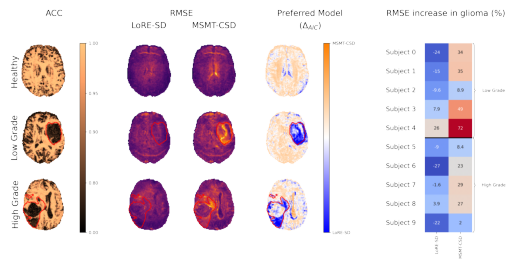

In [32]:
# Read all images and stitch them together horizontally with 500px padding
acc = mpimg.imread('/LOCALDATA/sleyse4/acc.png')
rmse = mpimg.imread('/LOCALDATA/sleyse4/rmse.png')
# aic = mpimg.imread('/LOCALDATA/sleyse4/aic.png')
selection = mpimg.imread('/LOCALDATA/sleyse4/selection.png')
glioma_incr = mpimg.imread('/LOCALDATA/sleyse4/heatmap.png')

max_height = max([img.shape[0] for img in [acc, rmse, selection, glioma_incr]])
min_height = min([img.shape[0] for img in [acc, rmse, selection, glioma_incr]])

print([img.shape[0] for img in [acc, rmse, selection, glioma_incr]])

assert max_height == min_height, f'Images have different heights ({max_height} vs {min_height})'

padding_width = 0
padding = np.ones((max_height, padding_width, 4), dtype=np.uint8)
padding[..., -1] = 0

# Concatenate images with padding
stitched_image = np.concatenate((acc, padding, rmse, padding, selection, padding, glioma_incr), axis=1)

left_white = np.where(np.any(stitched_image[...,-1] != 0, axis=0))[0][0]-5
right_white = np.where(np.any(stitched_image[...,-1] != 0, axis=0))[0][-1]+5
top_white = np.where(np.any(stitched_image[...,-1] != 0, axis=1))[0][0]-5
bottom_white = np.where(np.any(stitched_image[...,-1] != 0, axis=1))[0][-1]+5

# Save the stitched image
mpimg.imsave('/LOCALDATA/sleyse4/stitched_image.png', stitched_image[top_white:bottom_white, left_white:right_white])

# Display the stitched image
import matplotlib.pyplot as plt
plt.imshow(mpimg.imread('/LOCALDATA/sleyse4/stitched_image.png'))
plt.axis('off')
plt.show()